## Azure ML GAN Expriment

To use this notebook, you need to download `config.json` file from Azure ML Workspace and place it in this folder. This will allow us to get the workspace reference right away:

In [1]:
dataset = 'd:/data/wikiart/wikiart/impressionism'

In [2]:
from azureml.core import Workspace

try:
    ws = Workspace.from_config()
    print(ws.name, ws.location, ws.resource_group, ws.location, sep='\t')
    print('Library configuration succeeded')
except:
    print('Workspace not found')

W0317 00:46:31.167057 16900 __init__.py:76] Failure while loading azureml_run_type_providers. Failed to load entrypoint hyperdrive = azureml.train.hyperdrive:HyperDriveRun._from_run_dto with exception (azureml-core 1.0.83 (c:\winapp\miniconda3\lib\site-packages), Requirement.parse('azureml-core==1.0.79.*'), {'azureml-telemetry'}).
W0317 00:46:33.077243 16900 authentication.py:536] Warning: Falling back to use azure cli login credentials.
If you run your code in unattended mode, i.e., where you can't give a user input, then we recommend to use ServicePrincipalAuthentication or MsiAuthentication.
Please refer to aka.ms/aml-notebook-auth for different authentication mechanisms in azureml-sdk.


AzMLWorkspace	northeurope	AzureMLGroup	northeurope
Library configuration succeeded


Then make sure we have the compute cluster. If the cluster does not exist - we will create it programmatically!

In [4]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# Choose a name for your CPU cluster
cluster_name = "AzMLGPUCompute"

# Verify that cluster does not exist already
try:
    cluster = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='Standard_NC6',
                                                           vm_priority='lowpriority',
                                                           min_nodes=0,
                                                           max_nodes=4)
    cluster = ComputeTarget.create(ws, cluster_name, compute_config)

cluster.wait_for_completion(show_output=True)

Found existing cluster, use it.
Succeeded
AmlCompute wait for completion finished
Minimum number of nodes requested have been provisioned


Now upload the images dataset into the Azure ML Workspace:

In [ ]:
ds = ws.get_default_datastore()
ds.upload(dataset, target_path='dataset', overwrite=True)

Now let us create training script:

In [75]:
%%writefile train_gan.py
# KeraGAN trainer script

import argparse
import keragan
import keras
import os
import glob
from azureml.core.run import Run
import matplotlib.pyplot as plt

print("KeraGAN Trainer, version {}".format(keragan.__version__))

run = Run.get_context()

parser = argparse.ArgumentParser(description="KeraGAN Trainer")

parser.add_argument("--path",help="Azure ML Datastore dir")
parser.add_argument("--dataset",help="Dataset name within datastore")
parser.add_argument("--size",help="Image size to use", default=512, type=int)
parser.add_argument("--aspect_variance",help="Allowed aspect variance", default=0.5, type=float)
parser.add_argument("--model_path",help="Path to use for saving models", default='models')
parser.add_argument("--samples_path",help="Path to use for saving samples", default='samples')
parser.add_argument("--save_npy_path",help="Filename to save cached dataset for faster loading")
parser.add_argument("--limit",help="Limit # of images to use",type=int,default=None)
parser.add_argument("--batch_size",help="Minbatch size to use",type=int,default=128)
parser.add_argument("--save_interval",help="Epochs between saving models",type=int,default=100)
parser.add_argument("--save_img_interval",help="Epochs between generating image samples",type=int,default=100)
parser.add_argument("--print_interval",help="Epochs between printing",type=int,default=10)
parser.add_argument("--sample_images",help="View image sample",action='store_const',default=False,const=True)
parser.add_argument("--no_samples",help="Number of sample images to generate during training",type=int,default=10)
parser.add_argument("--latent_dim",help="Dimension of latent space",type=int,default=256)
parser.add_argument("--ignore_smaller",help="Ignore images smaller than required size",action='store_const',default=False,const=True)
parser.add_argument("--crop",help="Crop images to desired aspect ratio",action='store_const',default=False,const=True)
parser.add_argument("--epochs",help="Number of epochs to train",type=int,default=100)
parser.add_argument("--lr",help="Learning rate",type=float,default=0.0001)

args = parser.parse_args()

args.height = args.size
args.width = args.size
args.optimizer = None
args.path = os.path.join(args.path,args.dataset)

gan = keragan.DCGAN(args)
imsrc = keragan.ImageDataset(args)
imsrc.load()
train = keragan.GANTrainer(image_dataset=imsrc,gan=gan,args=args)

def callbk(tr):
    if tr.gan.epoch % 20 == 0:
        res = tr.gan.sample_images(n=3)
        fig,ax = plt.subplots(1,len(res))
        for i,v in enumerate(res):
            ax[i].imshow(v[0])
        run.log_image("Sample",plot=plt)

train.train(callbk)


Overwriting gantrain.py


Now let's submit the experiment to run:

In [5]:
from azureml.core import Experiment
#from azureml.train.estimator import Estimator
from azureml.train.dnn import TensorFlow

experiment_name = 'KeraGAN'
exp = Experiment(workspace=ws, name=experiment_name)
script_params = {
    '--path': ws.get_default_datastore(),
    '--dataset' : 'faces',
    '--model_path' : './outputs/models',
    '--samples_path' : './outputs/samples',
    '--batch_size' : 32,
    '--size' : 512,
    '--limit': 3000,
    '--epochs' : 10000
}

est = TensorFlow(source_directory='.',
                script_params=script_params,
                compute_target=cluster,
                entry_script='train_gan.py',
                use_gpu = True,
                conda_packages=['keras','tensorflow','opencv','tqdm','matplotlib'],
                #pip_packages=['imutils','opencv-python','git+https://github.com/shwars/keragan']
                pip_packages=['git+https://github.com/shwars/keragan@v0.0.1']
)

W0317 00:46:56.024998 16900 _framework_base_estimator.py:121] framework_version is not specified, defaulting to version 1.13.


In [8]:
run = exp.submit(est)

In [7]:
run

Experiment,Id,Type,Status,Details Page,Docs Page
KeraGAN,KeraGAN_1584017036_95b6872c,azureml.scriptrun,Starting,Link to Azure Machine Learning studio,Link to Documentation


### Downloading resulting images

After the experiment has completed, you can download resulting images to your local machine. If the experiment was long-running and the notebook session is lost, you can re-create it knowing the run id (which you can get from the portal). Otherwise you can use the same `run` variable from above (skip the cell below)

In [6]:
from azureml.core import Run
run = Run(experiment=exp,run_id='KeraGAN_1584048041337') # <-- provide run id from Azure Portal here
run.get_file_names()[:10]

['Sample_1584048189.png',
 'Sample_1584048230.png',
 'Sample_1584048271.png',
 'Sample_1584048311.png',
 'Sample_1584048353.png',
 'Sample_1584048396.png',
 'Sample_1584048438.png',
 'Sample_1584048479.png',
 'Sample_1584048520.png',
 'Sample_1584048562.png']

Следующая команда скачивает все сгенерированные сэмплы (которые наш скрипт помещал в директорию `outputs/samples`) на локальный компьютер. При этом в текущей директории появляется директория `outputs/samples` со всеми файлами.

In [23]:
run.download_files(prefix='outputs/samples')

## Getting the Model and Inferring New Images

Once we get the generator model, we can easily infer more images. To do that, let's find out the name of the latest model (it would have the highest epoch number) and download it:

In [7]:
fnames = list(filter(lambda x : x.startswith('outputs/models/gen_'), run.get_file_names()))
print(fnames[:5])
no = max(map(lambda x: int(x[19:x.find('.')]), fnames))
fname = 'outputs/models/gen_{}.h5'.format(no)
fname_wout_path = fname[fname.rfind('/')+1:]
run.download_file(fname)

['outputs/models/gen_0.h5', 'outputs/models/gen_100.h5', 'outputs/models/gen_1000.h5', 'outputs/models/gen_10000.h5', 'outputs/models/gen_10100.h5']


Now let's load the model in Keras, and also find out the size of latent noise vector (it is equivalend to the input size of the network): 

In [8]:
import keras
model = keras.models.load_model(fname_wout_path)
latent_dim=model.layers[0].input.shape[1].value

W0317 00:47:49.019360 16900 deprecation_wrapper.py:119] From C:\winapp\miniconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0317 00:47:49.057363 16900 deprecation_wrapper.py:119] From C:\winapp\miniconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0317 00:47:49.094364 16900 deprecation_wrapper.py:119] From C:\winapp\miniconda3\lib\site-packages\keras\backend\tensorflow_backend.py:2018: The name tf.image.resize_nearest_neighbor is deprecated. Please use tf.compat.v1.image.resize_nearest_neighbor instead.

W0317 00:47:49.124443 16900 deprecation_wrapper.py:119] From C:\winapp\miniconda3\lib\site-packages\keras\backend\tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0317 00:47:49.124443 16900 deprecation_wrapper.py

Now let's generate random noise vector and call the model to generate 10 random images. Output of the network is in the range $[-1,1]$, so we need to scale it linearly to the range $[0,1]$ in order to be correctly displayed by `matplotlib`:

In [62]:
import numpy as np
vec = np.random.normal(0,1,(10,latent_dim))
res = model.predict(vec))
res = (res+1.0)/2

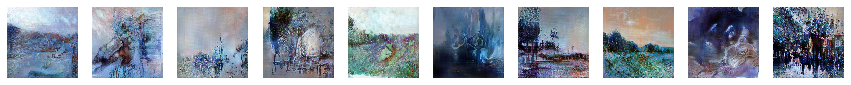

In [63]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,10,figsize=(15,10))
for i in range(10):
    ax[i].imshow(res[i])
    ax[i].axis('off')
plt.show()